# artificial reads benchmark

- uses simulated mbovis data at https://zenodo.org/records/5179838
- apply mask  

In [225]:
import sys,os,shutil,subprocess
import glob,tempfile,time
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
import seaborn as sns
sys.path.append('c:/Users/damien/projects/snipgenie/')
from snipgenie import tools, aligners, app, trees, plotting, simulate
from matplotlib_venn import venn2, venn3

## new calling method

In [ ]:
reload(app)
path = '/other/snipgenie_test/artificial_reads/'
args1 = {'threads':12, 'outdir': "/other/snipgenie_test/benchmark_results", 'labelsep':'_',
        'input':[path],      
        'reference': app.mbovis_genome,
        'get_stats':False,
        'custom_filters': False, 
        'proximity':0,
        'mask': None,
        'uninformative_sites': True,
        'buildtree':False}
W = app.WorkFlow(**args1)
st = W.setup()
W.run()

## run old calling method - uses simlink in output folder to previously mapped folder so we don't have to realign.

In [ ]:
args2 = {'threads':12, 'outdir': "/other/snipgenie_test/benchmark_results_old", 'labelsep':'_',
        'input':[path],        
        'reference': app.mbovis_genome,
        'get_stats':False,
        'custom_filters': False, 
        'proximity':0,
        'mask': None,     
        'uninformative_sites': True,
        'old_method':True,
        'buildtree':False}
W = app.WorkFlow(**args2)
st = W.setup()
W.run()

## run snippy

In [ ]:
outdir='/other/snipgenie_test/benchmark_results_snippy'
samples = pd.read_csv('/other/snipgenie_test/benchmark_results/samples.csv')
ref=app.mbovis_genome
mask = app.mbovis_mask
for i, r in samples.iterrows():
    out = os.path.join(outdir, r['sample'])    
    cmd = f'/local/snippy/bin/snippy --cpus 12 --force --minqual 60 --outdir {out} --ref {ref} --R1 {r.filename1} --R2 {r.filename2}'
    print (cmd)
    subprocess.check_output(cmd, shell=True)

In [ ]:
cmd = f'/local/snippy/bin/snippy-core /other/snipgenie_test/benchmark_results_snippy/*/ --ref /other/snipgenie_test/benchmark_results_snippy/ref.fa --mask {mask}'
print (cmd)
#subprocess.check_output(cmd, shell=True)

In [ ]:
v1 = tools.vcf_to_dataframe('/other/snipgenie_test/benchmark_results/filtered.vcf.gz')
v2 = tools.vcf_to_dataframe('/other/snipgenie_test/benchmark_results_old/snps.vcf.gz')

a=list(v1.mut.unique())
b=list(v2.mut.unique())
venn2([set(a),set(b)],('new','old'))

In [ ]:
reload(tools)
c1=pd.read_csv('/other/snipgenie_test/benchmark_results/core.txt',sep=' ')
c2=pd.read_csv('/other/snipgenie_test/benchmark_results_old/core.txt',sep=' ')
c3=pd.read_csv('/other/snipgenie_test/core.tab',sep='\t')
c3=c3.rename(columns={'POS':'pos'})
x,y=tools.compare_results(c1,c3)

In [ ]:
a=list(c1.pos)
b=list(c2.pos)
c=list(c3.pos)

## compare masked snps only

In [30]:
# Load masked regions
bed = pd.read_csv(app.mbovis_mask, sep='\t', header=None, names=['chrom', 'start', 'end'])
# Combine all BED ranges into a single list of intervals
masked_intervals = [(row.start, row.end) for _, row in bed.iterrows()]
# Function to check if a position is in any masked range
def is_unmasked(pos):
    return not any(start <= pos < end for start, end in masked_intervals)

# Filter positions
a_masked = [pos for pos in a if is_unmasked(pos)]
b_masked = [pos for pos in b if is_unmasked(pos)]
c_masked = [pos for pos in c if is_unmasked(pos)]

In [ ]:
sm1 = pd.read_csv('/other/snipgenie_test/benchmark_results/snpdist.csv',index_col=0)
sm2 = pd.read_csv('/other/snipgenie_test/benchmark_results_old/snpdist.csv',index_col=0)
#sm3 = pd.read_csv('/other/snipgenie_test/co',index_col=0)
#sm1

In [ ]:
sm1.sub(sm2).abs()

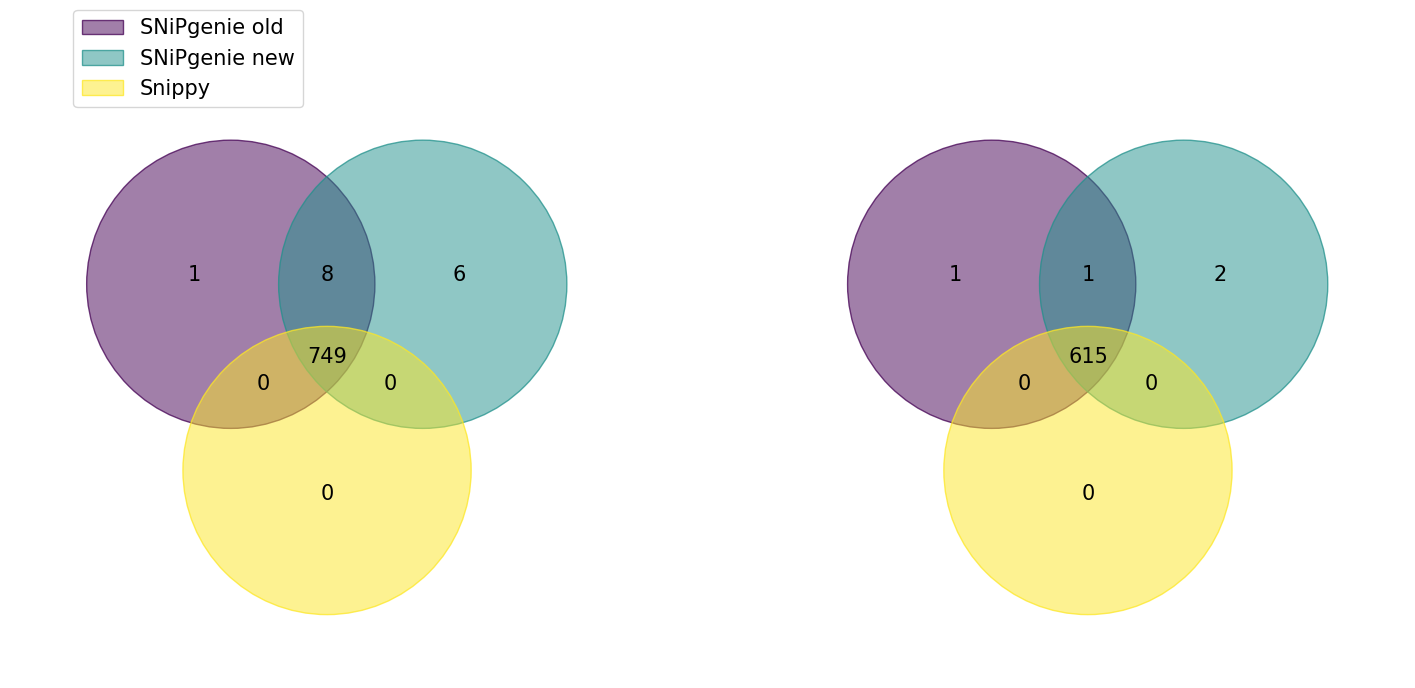

In [75]:
from venn import venn
data = {
    "SNiPgenie old": set(a),
    "SNiPgenie new": set(b),
     "Snippy": set(c) 
}
fig,ax=plt.subplots(1,2,figsize=(18, 12))
venn(data, alpha=0.5, legend_loc=(0.1,0.9), fontsize=15, ax=ax[0])
data = {
    "SNiPgenie old": set(a_masked),
    "SNiPgenie new": set(b_masked),
    "Snippy": set(c_masked)
}
venn(data, alpha=0.5, legend_loc=None, fontsize=15, ax=ax[1])
fig.savefig('venn.png',dpi=150)

## simulated sarscov2 genomes

In [168]:
#sim.newick is generated in the sim_phylo.R script, run that first
ref = app.sarscov2_genome
simulate.run_phastsim('sim.newick', ref)

phastSim --outpath phastsim_output/ --seed 1 --createFasta --createPhylip --treeFile sim.newick --scale 0.0003344146072300438 --invariable .1 --alpha 1.0 --omegaAlpha 1.0 --reference /home/farrell/.config/snipgenie/genome/Sars-Cov-2.fa


In [ ]:
#check simulated tree
from Bio import Phylo
tree = Phylo.read('sim.newick', "newick")
len(tree.get_terminals())

## speed test on simulated scov2 data

In [ ]:
reload(app)
simtestpath = '/other/snipgenie_test/sim_data_small'
times = []
threads=range(1,13)
for n in threads:
    tt = app.test_run(simtestpath, sample_size='small', simulate=False, overwrite=True, threads=n)
    times.append(tt)

In [ ]:
res = pd.DataFrame({'threads':threads,'time':times})
#res.to_csv('sim_test_large.csv',index=False)
ax=res.plot(x='threads',kind='bar',legend=True,figsize=(9,5))
#ax.set_ylim((6.5,7.6))
#res.to_csv('sim_test_small.csv',index=False)

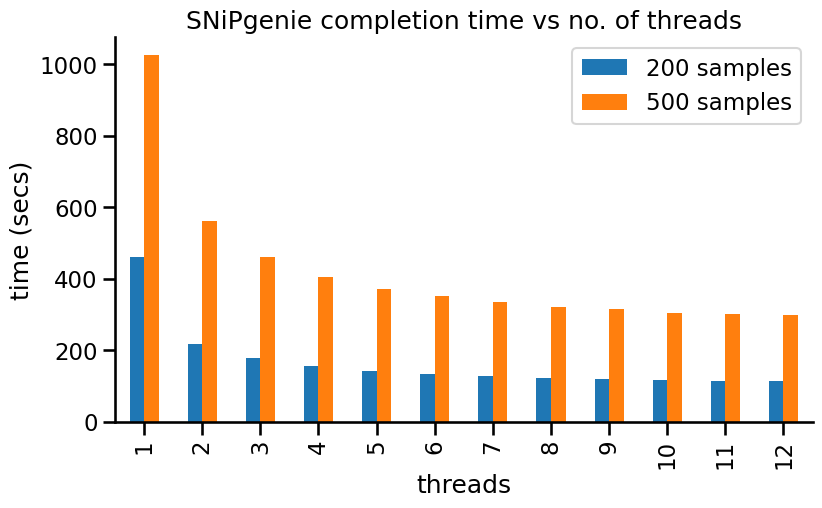

In [216]:
df0 = pd.read_csv('sim_test_small.csv')
df1 = pd.read_csv('sim_test_medium.csv')
df2 = pd.read_csv('sim_test_large.csv')
#df=df0.merge(df1,on='threads')
df=df1.merge(df2,on='threads')
df.columns=['threads','200 samples','500 samples']

sns.set_context('talk')
ax=df.plot(x='threads',kind='bar',legend=True,figsize=(9,5))
ax.set_title('SNiPgenie completion time vs no. of threads')
ax.set_ylabel('time (secs)')
sns.despine()

## scalibility to large samples

In [247]:
reload(app)
times = []
path = '/other/snipgenie_test/sim_data_large'
args = {'threads':8, 'outdir': "/other/snipgenie_test/benchmark_scaling", 'labelsep':'_',
        'input':[path],      
        'reference': app.sarscov2_genome,
        'get_stats':False,      
        'custom_filters': False, 
        'proximity':0,         
        'buildtree':False,
        'overwrite':True
        }

#times.append(tt)
samples = pd.read_csv('/other/snipgenie_test/samples_large.csv')
runsizes = range(10,500,50)
for n in runsizes:
    manifest = samples.sample(n)
    manifest.to_csv('manifest.csv',index=False)
    st=time.time()
    W = app.WorkFlow(**args, manifest='manifest.csv')
    W.setup()
    W.run()
    tt=time.time()-st
    times.append(tt)
    

The following options were supplied
time:  10/05/2025 11:27:25
-------
threads : 8
outdir : /other/snipgenie_test/benchmark_scaling
labelsep : _
input : ['/other/snipgenie_test/sim_data_large']
reference : /home/farrell/.config/snipgenie/genome/Sars-Cov-2.fa
get_stats : False
custom_filters : False
proximity : 0
buildtree : False
overwrite : True
manifest : manifest.csv
labelindex : 0
unmapped : False
quality : 25
aligner : bwa
platform : illumina
species : None
filters : QUAL>=40 && FORMAT/DP>=30 && DP4>=4
mask : None
uninformative_sites : False
gb_file : None
subset : None
old_method : False
bootstraps : 100
logfile : /other/snipgenie_test/benchmark_scaling/run.log

using manifest file for samples
10 samples were loaded:
----------------------
  sample                                          filename1                                          filename2  name1  name2
0    367  /other/snipgenie_test/sim_data_large/367_1.fas...  /other/snipgenie_test/sim_data_large/367_2.fas...  367_1  

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10338.44it/s]

bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/merged.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/bcffiles.txt
bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4" -o /other/snipgenie_test/benchmark_scaling/snps.vcf.gz -O z /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/indels.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/indelfiles.txt
bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/indels.vcf.gz
/other/snipgenie_test/benchmark_scaling/snps.vcf.gz

making SNP matrix
-----------------
uninformative_sites False
found 307 sites for core snps
0 sites with at least one missing sample
8 uninformative sites



Done. Sample summary:
---------------------
10 samples processed


The following options were supplied
time:  10/05/2025 11:27:32
-------
threads : 8
outdir : /other/snipgenie_test/benchmark_scaling
labelsep : _
input : ['/other/snipgenie_test/sim_data_large']
reference : /home/farrell/.config/snipgenie/genome/Sars-Cov-2.fa
get_stats : False
custom_filters : False
proximity : 0
buildtree : False
overwrite : True
manifest : manifest.csv
labelindex : 0
unmapped : False
quality : 25
aligner : bwa
platform : illumina
species : None
filters : QUAL>=40 && FORMAT/DP>=30 && DP4>=4
mask : None
uninformative_sites : False
gb_file : None
subset : None
old_method : False
bootstraps : 100
logfile : /other/snipgenie_test/benchmark_scaling/run.log

using manifest file for samples
50 samples were loaded:
----------------------
   sample                                          filename1                                          filename2  name1  name2
0     154  /other/snipgenie_test/sim_data_large/154

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 15140.80it/s]

bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/merged.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/bcffiles.txt
bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4" -o /other/snipgenie_test/benchmark_scaling/snps.vcf.gz -O z /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/indels.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/indelfiles.txt
bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/indels.vcf.gz
/other/snipgenie_test/benchmark_scaling/snps.vcf.gz

making SNP matrix
-----------------
uninformative_sites False


found 1138 sites for core snps
0 sites with at least one missing sample
8 uninformative sites

Done. Sample summary:
---------------------
50 samples processed


The following options were supplied
time:  10/05/2025 11:28:05
-------
threads : 8
outdir : /other/snipgenie_test/benchmark_scaling
labelsep : _
input : ['/other/snipgenie_test/sim_data_large']
reference : /home/farrell/.config/snipgenie/genome/Sars-Cov-2.fa
get_stats : False
custom_filters : False
proximity : 0
buildtree : False
overwrite : True
manifest : manifest.csv
labelindex : 0
unmapped : False
quality : 25
aligner : bwa
platform : illumina
species : None
filters : QUAL>=40 && FORMAT/DP>=30 && DP4>=4
mask : None
uninformative_sites : False
gb_file : None
subset : None
old_method : False
bootstraps : 100
logfile : /other/snipgenie_test/benchmark_scaling/run.log

using manifest file for samples
90 samples were loaded:
----------------------
   sample                                          filename1                      

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 90/90 [00:00<00:00, 12831.85it/s]

bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/merged.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/bcffiles.txt
bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4" -o /other/snipgenie_test/benchmark_scaling/snps.vcf.gz -O z /other/snipgenie_test/benchmark_scaling/merged.vcf.gz
bcftools merge --threads 8 -0 -O z -o /other/snipgenie_test/benchmark_scaling/indels.vcf.gz --file-list /other/snipgenie_test/benchmark_scaling/indelfiles.txt


bcftools reheader --samples /other/snipgenie_test/benchmark_scaling/samples.txt -o /tmp/calls.vcf /other/snipgenie_test/benchmark_scaling/indels.vcf.gz
/other/snipgenie_test/benchmark_scaling/snps.vcf.gz

making SNP matrix
-----------------
uninformative_sites False
found 1591 sites for core snps
0 sites with at least one missing sample
0 uninformative sites

Done. Sample summary:
---------------------
90 samples processed




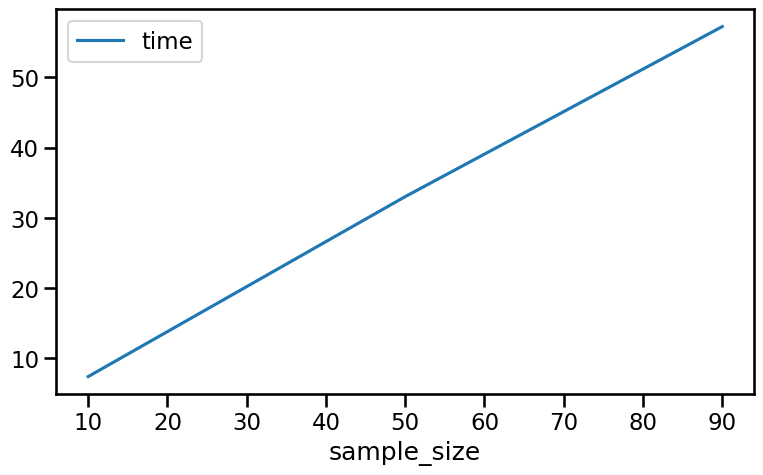

In [248]:
res = pd.DataFrame({'sample_size':runsizes,'time':times})
ax=res.plot(x='sample_size',legend=True,figsize=(9,5))